In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [6]:
df = pd.read_excel('C:\\Users\\user\\github\\Data\\hysteresis\\MCALIBRATION_7600_AND_7683.xlsx')

In [10]:
eda_df = df.iloc[:,:2]

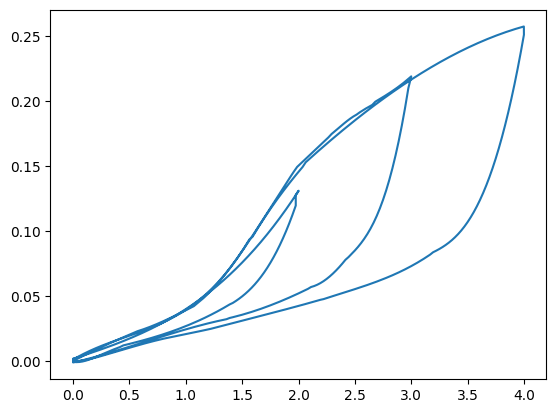

In [9]:
plt.plot(df.iloc[:,0], df.iloc[:,1])

In [12]:
eda_df

,Mullins (experimental)-1-x,Mullins (experimental)-1-y
0,-0.000551,0.001578
1,-0.001106,0.001562
2,0.024390,0.002280
3,0.054750,0.003138
4,0.082757,0.003936
...,...,...
655,0.111110,0.000739
656,0.083335,0.000278
657,0.055557,-0.000129
658,0.027786,-0.000475


In [34]:
import numpy as np
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [48]:
def ada_boost(X_train, y_train, X_test):
    AdaBoostRegressor.base_estimator_
    base_reg = DecisionTreeRegressor(max_depth= 7)
    model_ada = AdaBoostRegressor(estimator= base_reg,n_estimators=100,random_state=0, learning_rate=0.1)
    model_ada.fit(X_train, y_train)
    predict_ada = model_ada.predict(X_test)

    # model = AdaBoostRegressor(estimator= base_reg,n_estimators=100,random_state=0, learning_rate=0.1)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    return predict_ada

def xgboost(X_train, y_train, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    params = {'max_depth': 3, 'eta': 0.1, 'silent': 1, 'objective': 'reg:squarederror'}
    num_round = 100
    model = xgb.train(params, dtrain, num_round)
    y_pred = model.predict(dtest)
    return y_pred

def lstm(X_train, y_train, X_test, look_back):
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, X_train.shape[1])))  # modify input shape
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    X_train = X_train.reshape((15842, 3, 24))
    X_train = X_train.reshape(-1, look_back, X_train.shape[1])  # modify reshaping
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[1]))  # modify reshaping
    y_pred = model.predict(X_test_lstm)
    return y_pred.flatten()

def ensemble_predict(X_train, y_train, X_test, look_back, order, num_estimators):
    y_pred_ada = ada_boost(X_train, y_train, X_test, num_estimators)
    y_pred_xgb = xgboost(X_train, y_train, X_test)
    #X_test_lstm = X_test[-look_back:, :]  # get the last 'look_back' timesteps
    #y_pred_lstm = lstm(X_train, y_train, X_test_lstm, look_back)
    #y_pred_arima = arima(X_train, y_train, X_test, order)
    #y_pred = np.column_stack((y_pred_ada, y_pred_xgb, y_pred_lstm, y_pred_arima))
    y_pred = np.column_stack((y_pred_ada, y_pred_xgb))
    #weights = [0.25, 0.25, 0.25, 0.25]  # equal weighting
    weights = [0.5, 0.5]  # equal weighting
    weighted_predictions = np.average(y_pred, axis=1, weights=weights)
    return weighted_predictions

In [153]:
X_train, y_train = eda_df.iloc[:400,0], eda_df.iloc[:400,1]
X_test, y_test = eda_df.iloc[400:,0], eda_df.iloc[400:,1]
look_back = 3
order = (2, 1, 0)
num_estimators = 50


In [ ]:
y_pred = ensemble_predict(X_train, y_train, X_test, look_back, order, num_estimators)

In [94]:
xgb_pred = xgboost(X_train, y_train, X_test)

[19:37:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [96]:
r2_score(y_test.values, xgb_pred)

0.545558391229539

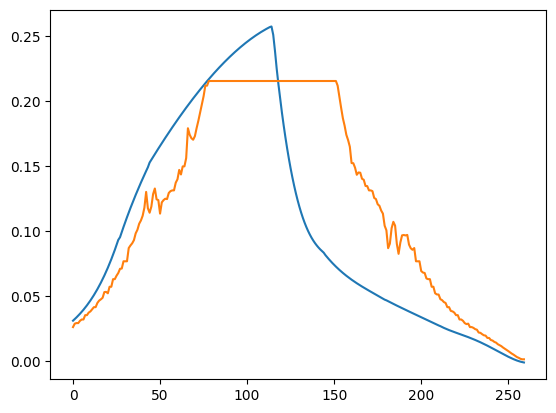

In [98]:
plt.plot(y_test.values)
plt.plot(xgb_pred)
plt.show()

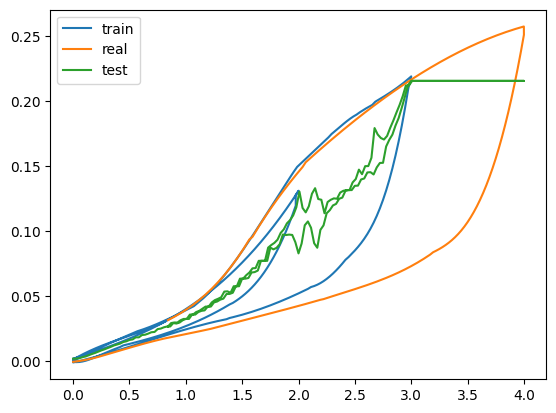

In [104]:
plt.plot(X_train, y_train, label = 'train')
plt.plot(X_test, y_test, label = 'real')
plt.plot(X_test, xgb_pred, label = 'test')
plt.legend()
plt.show()

In [107]:
import torch
import torch.nn as nn

In [268]:
n_input, n_hidden, n_out, batch_size, learning_rate = 1, 200, 1, 260, 0.01

In [254]:
torch_x_train = torch.FloatTensor(X_train.values).reshape(400,1)
torch_y_train = torch.FloatTensor(y_train.values).reshape(400,1)
torch_x_test = torch.FloatTensor(X_test.values).reshape(260,1)
torch_y_test = torch.FloatTensor(y_test.values).reshape(260,1)

In [255]:
print(torch_x_train.size())
print(torch_y_train.size())
print(torch_x_test.size())
print(torch_y_test.size())


torch.Size([400, 1])
torch.Size([400, 1])
torch.Size([260, 1])
torch.Size([260, 1])


In [269]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
  (3): Sigmoid()
)


In [270]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [276]:
losses = []
for epoch in range(100000):
    pred_y = model(torch_x_train)
    loss = loss_function(pred_y, torch_y_train)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

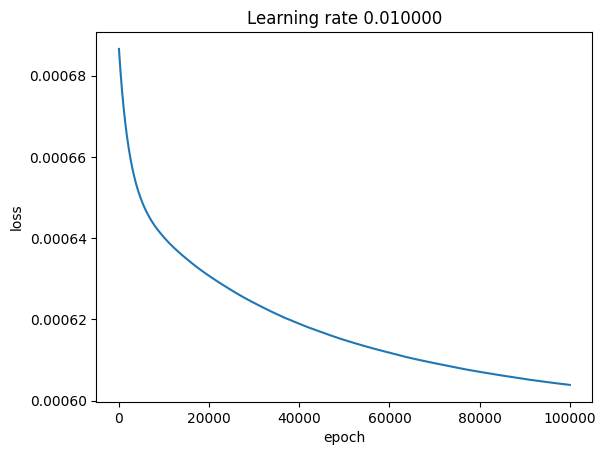

In [277]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [278]:
total = model(torch_x_test)

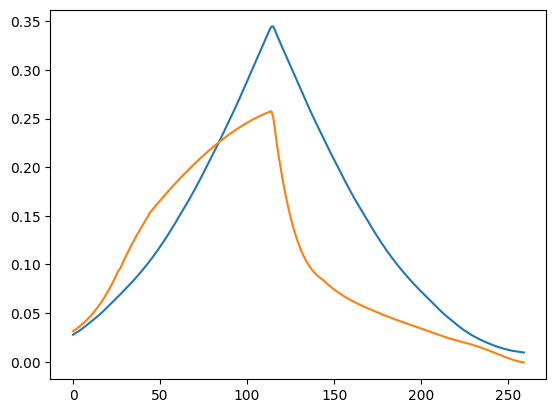

In [279]:
plt.plot(total.detach().numpy())
plt.plot(y_test.values)

In [280]:
r2_score(total.detach().numpy(), y_test.values)

0.48742137024850307

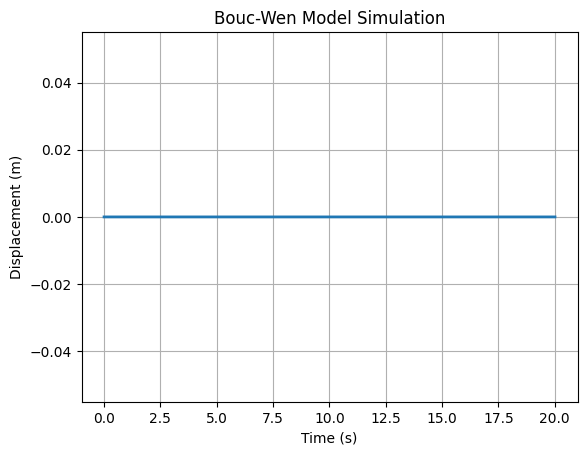

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set simulation parameters
t_start = 0
t_end = 20
dt = 0.01
t_span = np.arange(t_start, t_end+dt, dt)

# Set system parameters
xi = 0.01
omega = 2*np.pi*1
xp = 0.1
k = 1
h = 0.1
n = 1.5
theta = 0.1

# Set initial conditions
x0 = 0
y0 = 0

# Define external force function
def ext_force(t):
    return np.sin(2*np.pi*t)

# Define the Bouc-Wen equation
def bouc_wen(x, t):
    y = x[1]
    x = x[0]
    dxdt = np.zeros(2)
    dxdt[0] = y
    dxdt[1] = -2*xi*omega*y - omega**2*x + theta*ext_force(t)*(k/h)**(1/n)*abs(y)**(n-1)
    return dxdt

# Solve the equation numerically
x = odeint(bouc_wen, [x0, y0], t_span)

# Plot the results
plt.plot(t_span, x[:,0], linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Bouc-Wen Model Simulation')
plt.grid(True)
plt.show()


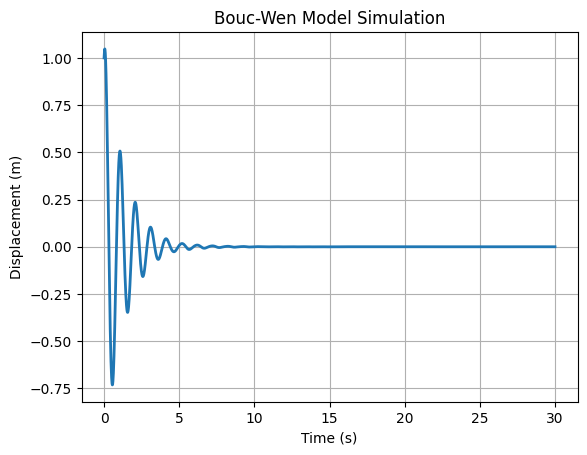

NameError: name 'y' is not defined

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set simulation parameters
t_start = 0
t_end = 30
dt = 0.01
t_span = np.arange(t_start, t_end+dt, dt)

# Set system parameters
xi = 0.1
omega = 2*np.pi*1
xp = 0.1
k = 1
h = 0.1
n = 1.5
theta = 0.1

# Set initial conditions
x0 = 1
y0 = 2

# Define external force function
def ext_force(t):
    if t <= 5:
        return np.sin(2*np.pi*t)
    elif t <= 10:
        return np.sin(4*np.pi*t)
    elif t <= 15:
        return np.sin(6*np.pi*t)
    else:
        return np.sin(8*np.pi*t)

# Define the Bouc-Wen equation
def bouc_wen(x, t):
    y = x[1]
    x = x[0]
    dxdt = np.zeros(2)
    dxdt[0] = y
    dxdt[1] = -2*xi*omega*y - omega**2*x + theta*ext_force(t)*(k/h)**(1/n)*abs(y)**(n-1)
    return dxdt

# Solve the equation numerically
x = odeint(bouc_wen, [x0, y0], t_span)

# Plot the results
plt.plot(t_span, x[:,0], linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Bouc-Wen Model Simulation')
plt.grid(True)
plt.show()

plt.scatter(x = x,y = y)
